# Example for HD Module 
This example aim to show the workflow of HD Solver though the analytic example from [Antuono (2020)](https://www.cambridge.org/core/journals/journal-of-fluid-mechanics/article/abs/triperiodic-fully-threedimensional-analytic-solutions-for-the-navierstokes-equations/0444128148C6D5217F6F78B8C9BB0219) and also explore if MHDflows could resolve the turbulence properties.

In [1]:
using MHDFlows
using PyCall,PyPlot
using FFTW,CUDA,Statistics
using LinearAlgebra: mul!, ldiv!

┌ Info: FourierFlows will use 4 threads
└ @ FourierFlows /home/doraho/.julia/packages/FourierFlows/DtzuG/src/FourierFlows.jl:123


In [2]:
device!(1)
print(device())

CuDevice(1)

In [3]:
function ProblemGeneratorTG!(prob,L0,U0;N = prob.grid.nx)
  R     = 0;

  # Output Setting  
  kx,ky,kz = fill(0.0,N,N,N),fill(0.0,N,N,N),fill(0.0,N,N,N);
  
  l = 2*π/L0;
    
  for k ∈ 1:N, j ∈ 1:N, i ∈ 1:N
    kx[i,j,k] = l*prob.grid.x[i];
    ky[i,j,k] = l*prob.grid.y[j];
    kz[i,j,k] = l*prob.grid.z[k];
  end
    
  pfactor =  4/3*sqrt(2/3);
    
  θ1 = asin(-(√(3)+R)/2/√(1+R^2));
  Φ1 = asin((√(3)-R)/2/√(1+R^2));
  ϕ1 = asin(1/(1+R^2));
    
  ux = @. (sin(kx+θ1)*cos(ky+Φ1)*sin(kz+ϕ1) - cos(kz+θ1)*sin(kx+Φ1)*sin(ky+ϕ1));
  
  uy = @. (sin(ky+θ1)*cos(kz+Φ1)*sin(kx+ϕ1) - cos(kx+θ1)*sin(ky+Φ1)*sin(kz+ϕ1));
  
  uz = @. (sin(kz+θ1)*cos(kx+Φ1)*sin(ky+ϕ1) - cos(ky+θ1)*sin(kz+Φ1)*sin(kx+ϕ1));


  copyto!(prob.vars.ux, U0*pfactor*ux);
  copyto!(prob.vars.uy, U0*pfactor*uy);
  copyto!(prob.vars.uz, U0*pfactor*uz);

  #Update V  Fourier Conponment
  uxh = prob.sol[:, :, :, prob.params.ux_ind];
  uyh = prob.sol[:, :, :, prob.params.uy_ind];
  uzh = prob.sol[:, :, :, prob.params.uz_ind];

  mul!(uxh, prob.grid.rfftplan, prob.vars.ux);   
  mul!(uyh, prob.grid.rfftplan, prob.vars.uy);
  mul!(uzh, prob.grid.rfftplan, prob.vars.uz);
    
  prob.sol[:, :, :, prob.params.ux_ind] .= uxh;
  prob.sol[:, :, :, prob.params.uy_ind] .= uyh;
  prob.sol[:, :, :, prob.params.uz_ind] .= uzh;
    
  HDupdatevars!(prob);
      
  return nothing
end


ProblemGeneratorTG! (generic function with 1 method)

# Re = 50 Case

In [4]:
#Simulation's parameters
N = 32;
Lx = 2π;
Re = 50;
U0 = 6.5
ν = 2*π*U0/Re;
dt = 1/500;

# Testing the problem
# Declare the problem on GPU
GPUprob  = HDProblem(GPU();nx = N,Lx = Lx,
                             ν = ν,
                            nν = 1,
              # Timestepper and equation options
                            dt = dt,
                       stepper = "RK4",
              # Float type and dealiasing
                             T = Float32);
GPUprob

Problem
  ├─────────── grid: grid (on GPU)
  ├───── parameters: params
  ├────── variables: vars
  ├─── state vector: sol
  ├─────── equation: eqn
  ├────────── clock: clock
  └──── timestepper: RK4TimeStepper

In [5]:
#function for monitoring the energy
function KEfoo(prob)
    vx,vy,vz = prob.vars.ux,prob.vars.uy,prob.vars.uz;
    return sum(vx.^2+vy.^2 + vz.^2)
end

KE = Diagnostic(KEfoo, GPUprob,freq=10);

In [6]:
CUDA.memory_status()
CUDA.reclaim()
GC.gc(true)
CUDA.memory_status()

Effective GPU memory usage: 13.50% (1.080 GiB/8.000 GiB)
CUDA allocator usage: 11.376 MiB
binned usage: 11.376 MiB (10.125 MiB allocated, 1.250 MiB cached)
Effective GPU memory usage: 13.50% (1.080 GiB/8.000 GiB)
CUDA allocator usage: 10.125 MiB
binned usage: 10.125 MiB (9.750 MiB allocated, 384.000 KiB cached)


In [7]:
# Set up the initial condition
ProblemGeneratorTG!(GPUprob,2π,U0);

t0 = 1
# Actaul computation
for i = 1:div(t0,dt)
    HDupdatevars!(GPUprob);
    stepforward!(GPUprob,KE,1)
end

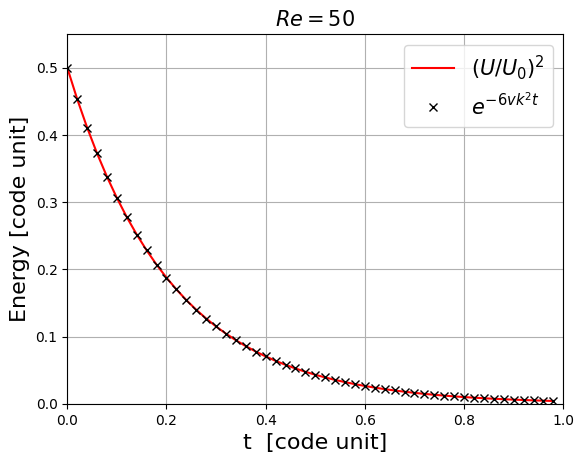

(0.0, 1.0)

In [8]:
#Plotting of the change of KE
t  = KE.t[1:end-5];
uu = KE.data[1:end-5];
uu[1] = U0^2*N^3;
nn = length(t)
k² = 1
v0 = 2*π*U0/Re;
plt.plot(t[1:nn],uu[1:nn]/uu[1]/2,"r",label=L"(U/U_0)^2")
plt.plot(t[1:1:nn],1/2*exp.(-6*v0*k²*(t[1:1:nn].-t[1])),"kx",label=L"e^{-6vk^2t}")
plt.title(L"Re ="*string(round(Re)),fontsize=15)
plt.legend(fontsize=15)
plt.xlabel("t  [code unit]",size=16)
plt.ylabel("Energy [code unit]",size=16)
plt.grid()
plt.ylim(0,0.55)
plt.xlim(0,1.0)

# Re = 1000 Case

In [9]:
#Simulation's parameters
N = 32;
Lx = 2π;
Re = 1000;
U0 = 6.5
ν = 2*π*U0/Re;
dt = 1/500;

# Testing the problem
# Declare the problem on GPU
GPUprob  = HDProblem(GPU();nx = N,Lx = Lx,
                             ν = ν,
                            nν = 1,
              # Timestepper and equation options
                            dt = dt,
                       stepper = "RK4",
              # Float type and dealiasing
                             T = Float32);
GPUprob

Problem
  ├─────────── grid: grid (on GPU)
  ├───── parameters: params
  ├────── variables: vars
  ├─── state vector: sol
  ├─────── equation: eqn
  ├────────── clock: clock
  └──── timestepper: RK4TimeStepper

In [10]:
# Set up the initial condition
ProblemGeneratorTG!(GPUprob,2π,U0);
KE = Diagnostic(KEfoo, GPUprob,freq=10);

t0 = 9
# Actaul computation
for i = 1:div(t0,dt)
    HDupdatevars!(GPUprob);
    stepforward!(GPUprob,KE,1)
end

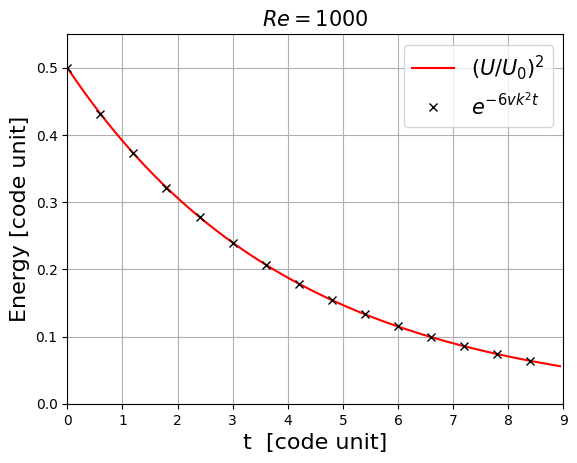

(0.0, 9.0)

In [11]:
#Plotting of the change of KE
t  = KE.t[1:end-2];
uu = KE.data[1:end-2];
uu[1] = U0^2*N^3;
nn = length(t)-1
k² = 1
v0 = 2*π*U0/Re;
plt.plot(t[1:nn],uu[1:nn]/uu[1]/2,"r",label=L"(U/U_0)^2")
plt.plot(t[1:30:nn],1/2*exp.(-6*v0*k²*(t[1:30:nn].-t[1])),"kx",label=L" e^{-6vk^2t}")
plt.title(L"Re ="*string(round(Re)),fontsize=15)
plt.legend(fontsize=15)
plt.xlabel("t  [code unit]",size=16)
plt.ylabel("Energy [code unit]",size=16)
plt.grid()
plt.ylim(0,0.55)
plt.xlim(0,9.0)

### Diference between MHDFlow and  Antuono (2020).
Instability doesn't arises from our simulation at Re = 1000, but we are always further check if instability happens in higher Re case with higher resolution

In [12]:
#Simulation's parameters
N = 256;
Lx = 2π;
Re = 5000;
U0 = 6.5
ν  = 2*π*U0/Re;
dt = 1/500;

# Testing the problem
# Declare the problem on GPU
GPUprob  = HDProblem(GPU();nx = N,Lx = Lx,
                             ν = ν,
                            nν = 1,
              # Timestepper and equation options
                            dt = dt,
                       stepper = "RK4",
              # Float type and dealiasing
                             T = Float32);
GPUprob

Problem
  ├─────────── grid: grid (on GPU)
  ├───── parameters: params
  ├────── variables: vars
  ├─── state vector: sol
  ├─────── equation: eqn
  ├────────── clock: clock
  └──── timestepper: RK4TimeStepper

In [15]:
CUDA.memory_status()
CUDA.reclaim()
GC.gc(true)
CUDA.memory_status()

Effective GPU memory usage: 65.01% (5.201 GiB/8.000 GiB)
CUDA allocator usage: 4.101 GiB
binned usage: 4.101 GiB (4.101 GiB allocated, 0 bytes cached)
Effective GPU memory usage: 65.01% (5.201 GiB/8.000 GiB)
CUDA allocator usage: 4.101 GiB
binned usage: 4.101 GiB (4.101 GiB allocated, 0 bytes cached)


In [16]:
# Set up the initial condition
ProblemGeneratorTG!(GPUprob,2π,U0);
KE = Diagnostic(KEfoo, GPUprob,freq=10);

t0 = 8
# Actaul computation
for i = 1:div(t0,dt)
    HDupdatevars!(GPUprob);
    stepforward!(GPUprob,KE,1)
end

From Re~5000 case, we observe the instability behavior in our solver at t ~ 6.5

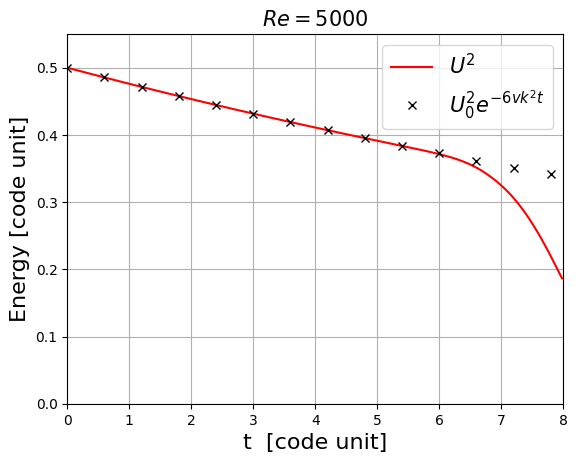

(0.0, 8.0)

In [27]:
#Plotting of the change of KE
t  = KE.t[1:end-2];
uu = KE.data[1:end-2];
uu[1] = U0^2*N^3;
nn = length(t)-5
k² = 1
v0 = 2*π*U0/Re;
plt.plot(t[1:nn],uu[1:nn]/uu[1]/2,"r",label=L"U^2")
plt.plot(t[1:30:nn],1/2*exp.(-6*v0*k²*(t[1:30:nn].-t[1])),"kx",label=L"U_0^2 e^{-6vk^2t}")
plt.title(L"Re ="*string(round(Re)),fontsize=15)
plt.legend(fontsize=15)
plt.xlabel("t  [code unit]",size=16)
plt.ylabel("Energy [code unit]",size=16)
plt.grid()
plt.ylim(0,0.55)
plt.xlim(0,8.0)


To see if it is an instability driven turbulence, we check its spectrum and strcuture in below.

In [18]:
#Spectrun Function
#Athor: KH Yuen 
function spectrallines3D(A::Array)
 nx,ny,nz=size(A);
 nl=round(Int,sqrt(nx^2+ny^2+nz^2));
 kn=zeros(nl);
 kl=zeros(nl);
 Ax2=fftshift((abs.(fft(A))).^2.0);
 for i in 1:nx, j in 1:ny, k in 1:nz
  idx=i-div(nx,2);
  jdx=j-div(ny,2);
  kdx=k-div(nz,2);
  rr=round(Int,sqrt(idx^2+jdx^2+kdx^2));
  if ((rr<=nl) & (rr>0))
   kn[rr]+=Ax2[i,j,k];
   kl[rr]=rr;
  end
 end
 return kn,kl
end

uxc = Array(GPUprob.vars.ux);
uyc = Array(GPUprob.vars.uy);
uzc = Array(GPUprob.vars.uz);
E = uxc.^2 + uyc.^2 + uzc.^2;
y,x = spectrallines3D(E);

## Conclusion
One can see the structure of velocity become fully chaotic from its initial state (LHS figure) while a power law relationship can be observed for the energy spectrum (RHS figure). We may safety say the Tri-periodic vortrex settup caused at instability in high Re and a turbulence behavior is captured by the MHDFlow solver, in particalar both its structure and its powerlaw spectrum.


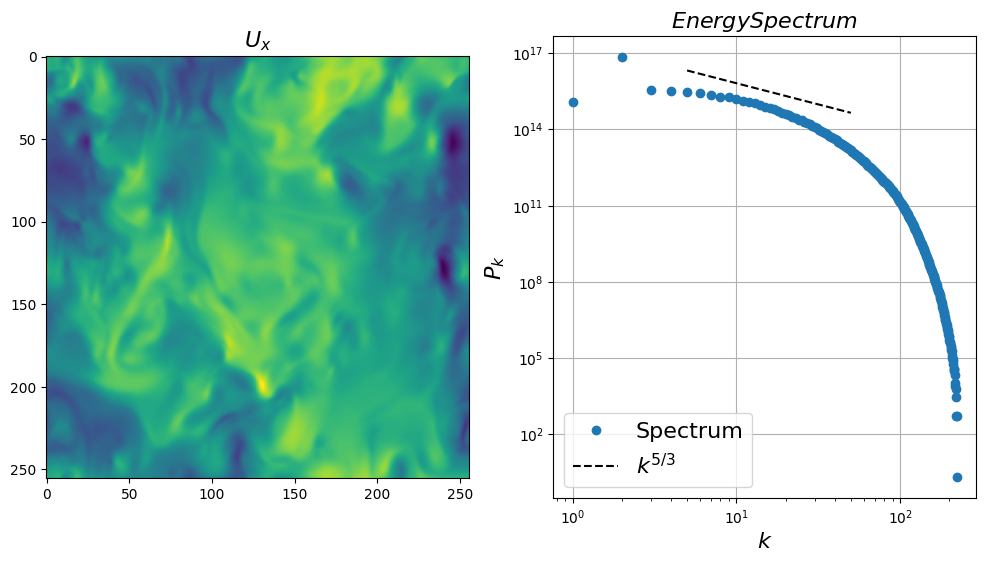

PyObject <matplotlib.legend.Legend object at 0x7f8a9176b828>

In [24]:
figure(figsize=(12,6))
subplot(121)
imshow(uxc[:,:,5])
title(L"U_x",size=16)
subplot(122)
loglog(x,y,"o",label="Spectrum");
loglog(x[5:50],y[5]*x[5:50].^(-5/3)*100,"k--",label=L"k^{5/3}")
ylabel(L"P_k}",size=16)
xlabel(L"k",size=16)
title(L"Energy Spectrum",size=16)
grid()
legend(fontsize=16)